## Quora Insincere Question Classification

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

 (1) Has a non-neutral tone      
- Has an exaggerated tone to underscore a point about a group of people
- Is rhetorical and meant to imply a statement about a group of people

(2) Is disparaging or inflammatory
- Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
- Makes disparaging attacks/insults against a specific person or group of people
- Based on an outlandish premise about a group of people
- Disparages against a characteristic that is not fixable and not measurable

(3) Isn't grounded in reality
- Based on false information, or contains absurd assumptions

(4) Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

### 1.Data Exploration

In [1]:
# import Libraries needed for analysis
import pandas as pd
import numpy as np
import operator 
import re
import string  
from nltk.corpus import stopwords

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siyaopeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Data Population:** Data used will be from the [Kaggle Quora Classification Competition](https://www.kaggle.com/c/quora-insincere-questions-classification/data)

In [2]:
# Import the training dataset
train = pd.read_csv('train.csv')
print(train.shape)
train[:5]

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


**Initial Data Exploration:** We see that there are 1,306,122 rows in our training data, each containing a Question ID, Question Text, and an indicator of whether the question was classified as sincere (0) or insincere (1). We can do additional exploration into the differences between these classes, based on our training data.

In [3]:
## target count
cnt = train.target.value_counts()
cnt

0    1225312
1      80810
Name: target, dtype: int64

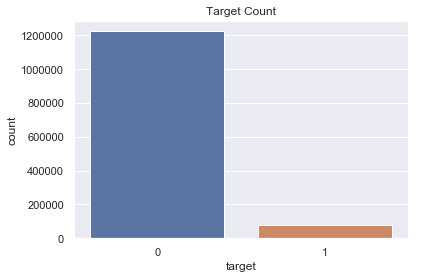

In [4]:
## Create a bar plot of the number of insincere vs sincere questions
sns.set(style="darkgrid")
ax = sns.countplot(x="target", data=train).set_title('Target Count')

In [5]:
## Find the percentage of insincere questions in our dataset
len(train[train.target==1])/len(train.question_text) 

0.06187017751787352

This is very imbalanced data. Only 6% of the training population questions are insincere questions. When building model, we might need to consider the following options to create more balanced data,
 

*   Undersampling
*   Supplement our data with synthetic or fake insincere questions (~20%) [Reference: Snorkel.org](https://www.snorkel.org/get-started/)
*   Remove some of the sincere questions (~20-30%) - this will also help make running code more managable
* To make our training data more manageable, we can reserve some of the labelled training data for testing to determine how well our model is labelling the questions




**Accuracy of Labels:** We see that some of the labels do not agree with our own intuition. For example, a question containing the text "Have you licked the skin of a corpse?" (Question ID 0000bc0f62500f55959f) has been labelled as sincere. If enough questions have been mis-labeled, there is potential that this could affect the accuracy of our model. 

**Explore Differences in Classes:** Now we try to compare the classes on several factors including,

1. Question Length - how many words are included in the question?
2. Punctuation - are there differences in the amount of punctuation marks included in a sincere vs. insincere question?
3. Word Case - how many uppercased words are included in the question?
4. Average Word Length - what is the average length of words included in the question?




In [6]:
## Generate some new variables to help understand our questions

# Number of words in each class
train['num_words'] = train['question_text'].apply(lambda x: len(str(x).split()))

# Number of punctuation marks in each class
train['num_punc'] = train['question_text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

# Number of uppercase words in each class
train['num_words_upper'] = train['question_text'].apply(lambda x: len([i for i in str(x).split() if (i.isupper())&(len(i)>1)]))

# Average Word length in Questions
#words = train['question_text'].split()
#train['average_word_len'] = sum(len(word) for word in words) / len(words)

## Truncate some extreme values for better visuals ##
train['num_words'].loc[train['num_words']>60] = 60 #truncation for better visuals
train['num_punc'].loc[train['num_punc']>10] = 10 #truncation for better visuals


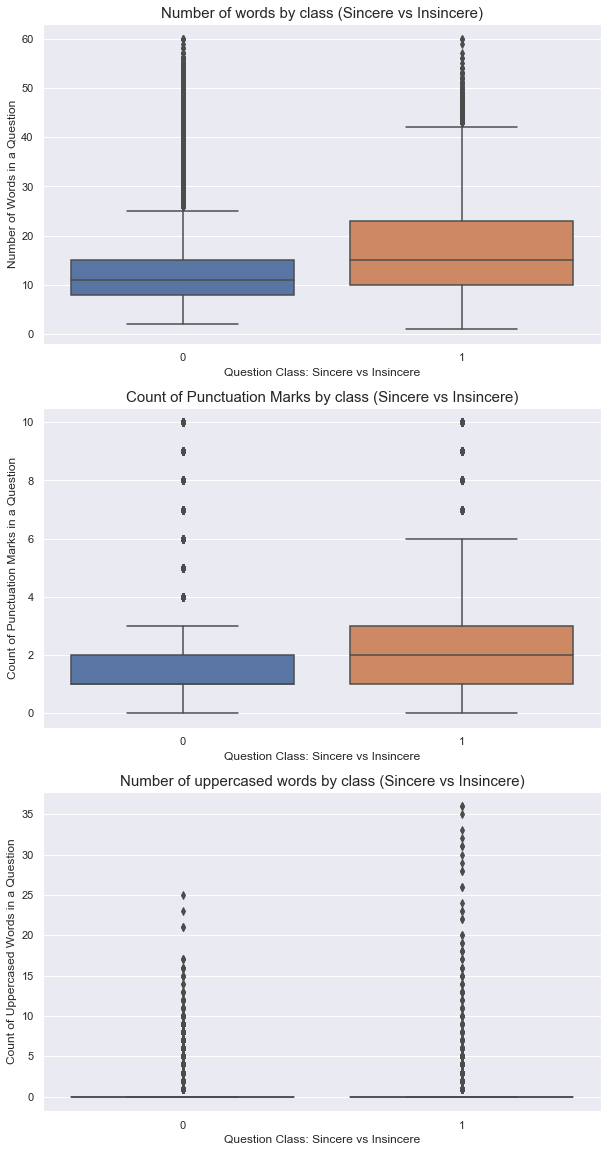

In [7]:
f, axes = plt.subplots(3,1, figsize=(10,20))
sns.boxplot(x='target', y = 'num_words', data = train, ax=axes[0])
axes[0].set_xlabel('Question Class: Sincere vs Insincere', fontsize=12)
axes[0].set_ylabel('Number of Words in a Question', fontsize=12)
axes[0].set_title("Number of words by class (Sincere vs Insincere)", fontsize=15)

sns.boxplot(x='target', y = 'num_punc', data= train, ax=axes[1])
axes[1].set_xlabel('Question Class: Sincere vs Insincere', fontsize=12)
axes[1].set_ylabel('Count of Punctuation Marks in a Question', fontsize=12)
axes[1].set_title("Count of Punctuation Marks by class (Sincere vs Insincere)", fontsize=15)

sns.boxplot(x='target', y='num_words_upper', data=train, ax=axes[2])
axes[2].set_xlabel('Question Class: Sincere vs Insincere', fontsize=12)
axes[2].set_ylabel('Count of Uppercased Words in a Question', fontsize=12)
axes[2].set_title("Number of uppercased words by class (Sincere vs Insincere)", fontsize=15)
plt.show()

From these plots, we notice insincere questions tend to have more words and more punctuations, they are also more likely to have upper words.

In [8]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    text = text.translate(str.maketrans('', '', string.punctuation))
    token = [token for token in text.lower().split(" ") if (token != "") & (token not in stopwords.words('english'))]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## sincere question
good = train[train.target==0]
bad = train[train.target==1]

In [9]:
### One Word
from collections import defaultdict
freq_dict = defaultdict(int)
for q in good["question_text"][1:60000]:
    for word in generate_ngrams(q):
        freq_dict[word] += 1

good_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x:x[1], reverse=True))[0:20]
good_sorted.columns = ["word", "wordcount"]

freq_dict = defaultdict(int)
for q in bad["question_text"]:
    for word in generate_ngrams(q):
        freq_dict[word] += 1
bad_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))[0:20]
bad_sorted.columns = ["word", "wordcount"]

Text(0.5, 1.0, 'Frequent Words For Sincere Questions')

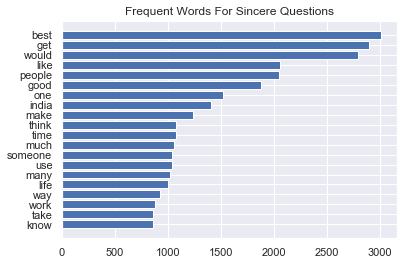

In [10]:
plt.barh(good_sorted.word[::-1], good_sorted.wordcount[::-1])
plt.title('Frequent Words For Sincere Questions')

Text(0.5, 1.0, 'Frequent Words For Insincere Questions')

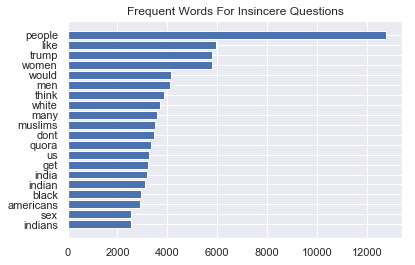

In [11]:
plt.barh(bad_sorted.word[::-1], bad_sorted.wordcount[::-1])
plt.title('Frequent Words For Insincere Questions')

**Observations:**

- The top words in the sincere questions include 'best', 'good', 'would' etc. - this seems to suggest that people are often looking for recommendations in sincere questions  
- The top words in the insincere questions include 'trump', 'women', 'white' etc. - this may suggest that many of the insincere questions are racially or politically charged.
- There are some words, including 'think', 'many', 'people' and 'would' that show up often in both sincere and insincere questions. The presence of these words likely won't be helpful in classifiying questions as sincere or insincere


### 2.Data Augmentation

Data Augmentation is a good way to mitigate imbalance problem. There are several approaches:      
(1) Tokenize texts into sentences, shuffling those sentences and rejoin them to generate new texts.    
(2) Synonym Replacement: Randomly choose n words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random.   

##### Approach One

In [12]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/siyaopeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siyaopeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
from nltk import sent_tokenize
import random
def tokenize(text):
    '''text: list of text documents'''
    tokenized =  sent_tokenize(text)
    return tokenized

augmented = []

random.seed(1)
for ng_rev in train[train.target==1]['question_text']:
    tok = tokenize(ng_rev)
    n = len(tok)
    while n > 1:
        random.shuffle(tok)
        new_rev = ' '.join(tok)
        if new_rev != ng_rev and new_rev not in augmented :           
            augmented.append(new_rev)
        n -= 1
len(augmented)

15172

In this step, 15171 questions are created.

In [14]:
from nltk.corpus import wordnet

### randomly replace two words with their synonyms in a question
augmented2 = []
random.seed(0)
for ng_rev in train[train.target==1]['question_text']:
    words = str(ng_rev).split()  
    r2 = random.sample(range(0, len(words)), 1)
    for i in r2:
        syns = wordnet.synsets(words[i])
        if len(syns)>1:
            words[i] = [s.name() for s in syns][1].split('.')[0]  
    augmented2.append(' '.join(words))

### randomly replace four words with their synonyms in a question
augmented3 = []
random.seed(0)
for ng_rev in train[train.target==1]['question_text']:
    words = str(ng_rev).split()  
    if len(words)>=3:
        r3 = random.sample(range(0, len(words)), 3)
        for i in r3:
            syns = wordnet.synsets(words[i])
            if len(syns)>1:
                words[i] = [s.name() for s in syns][1].split('.')[0]  
        augmented3.append(' '.join(words))

### randomly replace five words with their synonyms in a question
augmented4 = []
random.seed(0)
for ng_rev in train[train.target==1]['question_text']:
    words = str(ng_rev).split()  
    if len(words)>=5:
        r5 = random.sample(range(0, len(words)), 5)
        for i in r5:
            syns = wordnet.synsets(words[i])
            if len(syns)>1:
                words[i] = [s.name() for s in syns][1].split('.')[0]  
        augmented4.append(' '.join(words))

In [15]:
len(augmented2+augmented3+augmented4)

241133

In approach two 232047 questions are created.

In [16]:
aug = augmented + augmented2 + augmented3 +augmented4
label=[1]*len(aug)
fakedf = pd.DataFrame({'question_text':aug, 'target': label})
fakedf.shape

(256305, 2)

Now we do the following processing:     
(1) remove sincere questions which are too short or too long;    
(2) combine the given dataset and fake dataset together, only keep 'question_text' and 'target' two features.      
(3) remove duplicate questions.

In [17]:
# delete sincere questions which have less than 8 words or more than 35 words:
dtrain = train.drop(train[(train.target==0) & ((train.num_words<8) | (train.num_words>35))].index).reset_index()
dtrain.shape

(1046016, 7)

In [18]:
data = dtrain[['question_text','target']].append(fakedf)
data = data.drop_duplicates(keep=False)
data.shape

(1135502, 2)

In [19]:
len(data[data.target==1])/len(data.question_text) 

0.14997419643470464

Finally, insincere questions account for 15%.

In [22]:
data.to_csv('aug_data.csv')

Considering computation limit, I will randomly remove 400000 questions which are classified as sincere questions. This also helps mitigate imbalance problem.

In [11]:
np.random.seed(0)
drop_indices = np.random.choice(data[data.target==0].index, 400000, replace=False)
clean_data = data.drop(drop_indices)
clean_data.to_csv('clean_data.csv')

In [14]:
clean_data.target.value_counts()

0    565206
1    170296
Name: target, dtype: int64